<a href="https://colab.research.google.com/github/shanikairoshi/Communication-Efficient-DUQFL/blob/main/main_v2_1.2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# %%capture
!pip install genomic-benchmarks
!pip install qiskit qiskit_machine_learning qiskit_algorithms qiskit-aer




In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import sys
from pathlib import Path
PROJ = Path.cwd() / "tduqfl_Project_AGG"
if str(PROJ) not in sys.path:
    sys.path.insert(0, str(PROJ))
import sys
sys.path.append('/content/drive/MyDrive/Teleportation/tduqfl_Project_AGG/tDuQFL_Project')
# ─── 5. Assemble filenames for each artifact ─────────────────────────────────
#drive_root = "/content/drive/MyDrive/Teleportation/tduqfl_Project_AGG/tDuQFL_Project/"

In [4]:
from common.imports import *
from configs.dataset_genome_iid import *     # swap to other configs as needed
from io_utils.naming import stamp_now, flags, build_param_str, make_filenames

start_str, date_str = stamp_now()
teleport_pl, noise_pl = flags(use_teleportation, use_noise)
param_str = build_param_str(num_clients, num_federated_layers, num_deep_unfolding_iterations,
                            initial_learning_rate, initial_perturbation)

best_client_csv_file, global_csv_file, local_csv_file, validation_csv_file = make_filenames(
    drive_root, dataset_name, split_type, date_str, teleport_pl, noise_pl, param_str
)
from io_utils.csv_logger import init_local_csv, init_best_csv, init_validation_csv

# Create folders + write headers
init_best_csv(best_client_csv_file)

local_headers = [
    "Federated Round", "Client Number", "Iteration",
    "Objective Function Value", "Training Accuracy", "Test Accuracy",
    "Learning Rate", "Perturbation"
]
init_local_csv(local_csv_file, local_headers)

init_validation_csv(validation_csv_file)

# Do NOT pre-init global_csv_file here because your save_accuracies_to_csv()
# already writes the header each time it runs (in 'w' mode).

/usr/local/lib/python3.12/dist-packages/genomic_benchmarks/utils/datasets.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Python: 3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]
Qiskit: 1.4.4
qiskit_aer available?: True


Load and Split data

In [5]:
from data.preprocess_genome import load_and_prepare_dataset
from data.splitters import split_dataset_for_epochs
from configs.base_config import (
    num_clients, num_epochs, samples_per_epoch, split_type,
    global_seed
)

np_train_data, np_test_data = load_and_prepare_dataset(word_size, global_seed)

# 2) Compute feasible epoch capacity and cap both epochs and rounds
N_train = len(np_train_data)
train_capacity = N_train // (num_clients * samples_per_epoch)
num_epochs_eff = max(1, min(num_epochs, train_capacity))

if train_capacity == 0:
    raise ValueError(
        f"Not enough training samples ({N_train}) for "
        f"{num_clients=} × {samples_per_epoch=} per epoch. "
        "Reduce samples_per_epoch or num_clients, or enable resampling."
    )

num_federated_layers_eff = min(num_federated_layers, num_epochs_eff)

# Build clients
if split_type.lower() == "iid":
    from data.splitters import split_dataset_for_epochs
    clients = split_dataset_for_epochs(
        num_clients=num_clients,
        num_epochs=num_epochs_eff,             # or num_epochs
        train_data=np_train_data,
        test_data=np_test_data,
        samples_per_epoch=samples_per_epoch,
    )
elif split_type.lower() in {"noniid", "non-iid", "non_iid"}:
    from data.noniid import make_non_iid_clients
    clients = make_non_iid_clients(
        train_data=np_train_data,
        test_data=np_test_data,
        num_clients=num_clients,
        num_epochs=num_epochs_eff,             # or num_epochs
        samples_per_epoch=samples_per_epoch,
        non_iid_ratio=0.8,                     # tune as needed
        quantity_variation=0.5,                # tune as needed
        seed=global_seed,
        plot=True
    )
else:
    raise ValueError(f"Unknown split_type: {split_type}")

'''
clients = split_dataset_for_epochs(
    num_clients=num_clients, num_epochs=num_epochs,
    train_data=np_train_data, test_data=np_test_data,
    samples_per_epoch=samples_per_epoch
)
'''
# validation/tables
test_sequences = np.array([d["sequence"] for d in np_test_data])
test_labels    = np.array([d["label"]    for d in np_test_data])
X_val, y_val   = test_sequences, test_labels

# derive num_features once
if clients and clients[0].data and clients[0].data[0]:
    num_features = clients[0].data[0][0]['sequence'].shape[0]
else:
    raise RuntimeError("Empty client data – check splitting indices.")


In [6]:
# Infer num_features from the first available sample in clients
def infer_num_features_from_clients(clients):
    for c in clients:
        for epoch_data in c.data:              # list of samples for that epoch
            if not epoch_data:
                continue
            sample = epoch_data[0]
            if "sequence" in sample:           # your Genome pipeline
                arr = np.asarray(sample["sequence"])
                return int(arr.size)
            if "features" in sample:           # some other pipelines
                arr = np.asarray(sample["features"])
                return int(arr.size)
            if "image" in sample:              # e.g., MNIST before flatten
                arr = np.asarray(sample["image"]).reshape(-1)
                return int(arr.size)
            # add any other key you use
    raise RuntimeError("Could not infer num_features: no samples found.")

num_features = infer_num_features_from_clients(clients)
print(f"[info] num_features = {num_features}")


[info] num_features = 5


run federated loop and plot

Training Progress:   0%|          | 0/10 [00:00<?, ?it/s]

[Round 0] Teleportation OFF | Aggregation=best
[round 0 | client 0] seed LR=0.1200000000 (prev=0.1200000000), seed PERT=0.1200000000 (prev=0.1200000000), gamma=0.50


Deep Unfolding Iteration 1/5
[meta] cb#005 loss=0.479299 step=0.02947 g_raw=+0.014 g_sm=+0.002 acc=1 | LR→0.120240 PERT→0.120000 (scale=0.04)
[meta] cb#010 loss=0.472118 step=0.0781 g_raw=+0.038 g_sm=+0.007 acc=1 | LR→0.120481 PERT→0.120000 (scale=0.04)
[meta] cb#015 loss=0.468913 step=0.06626 g_raw=+0.029 g_sm=+0.009 acc=1 | LR→0.120722 PERT→0.120000 (scale=0.04)
[meta] cb#020 loss=0.461321 step=0.05936 g_raw=+0.026 g_sm=+0.012 acc=1 | LR→0.120964 PERT→0.120001 (scale=0.04)
[meta] cb#025 loss=0.457949 step=0.01423 g_raw=+0.006 g_sm=+0.012 acc=1 | LR→0.121207 PERT→0.120001 (scale=0.04)
[client 0 | unfold 1] LR_used=0.1200000000, PERT_used=0.1200000000 → LR_next=0.1212068865, PERT_next=0.1200008578
[meta-summary] callbacks=25 g_raw_mean=+0.016 g_sm_mean=+0.007 acc_ratio=1.00 | LR 0.1200000000→0.1212068865 PERT 0.1200000000

Training Progress:  10%|█         | 1/10 [09:28<1:25:19, 568.78s/it]

[Round   0] acc_g=0.723 (μ=0.708, σ=0.044, FG=0.096) | t=558.387s, val=0.542 | TEL=FALSE
[Round 1] Teleportation OFF | Aggregation=best
[round 1 | client 0] seed LR=0.1230799679 (prev=0.1261599358), seed PERT=0.1200035216 (prev=0.1200070431), gamma=0.50


Deep Unfolding Iteration 1/5
[meta] cb#005 loss=0.458804 step=0.05755 g_raw=+0.024 g_sm=+0.004 acc=1 | LR→0.123326 PERT→0.120004 (scale=0.04)
[meta] cb#010 loss=0.455930 step=0.009914 g_raw=+0.006 g_sm=+0.006 acc=1 | LR→0.123573 PERT→0.120004 (scale=0.04)
[meta] cb#015 loss=0.449429 step=0.07883 g_raw=+0.032 g_sm=+0.009 acc=1 | LR→0.123821 PERT→0.120004 (scale=0.04)
[meta] cb#020 loss=0.441075 step=0.05803 g_raw=+0.023 g_sm=+0.012 acc=1 | LR→0.124069 PERT→0.120004 (scale=0.04)
[meta] cb#025 loss=0.440189 step=0.03652 g_raw=+0.016 g_sm=+0.011 acc=1 | LR→0.124318 PERT→0.120004 (scale=0.04)
[client 0 | unfold 1] LR_used=0.1230799679, PERT_used=0.1200035216 → LR_next=0.1243178376, PERT_next=0.1200043860
[meta-summary] callbacks=25 g_raw_m

Training Progress:  20%|██        | 2/10 [18:46<1:14:59, 562.47s/it]

[Round   1] acc_g=0.741 (μ=0.711, σ=0.055, FG=0.120) | t=548.020s, val=0.543 | TEL=FALSE
[Round 2] Teleportation OFF | Aggregation=best
[round 2 | client 0] seed LR=0.1246987951 (prev=0.1293975902), seed PERT=0.1200050892 (prev=0.1200101783), gamma=0.50


Deep Unfolding Iteration 1/5
[meta] cb#005 loss=0.468376 step=0.07808 g_raw=+0.030 g_sm=+0.005 acc=1 | LR→0.124948 PERT→0.120005 (scale=0.04)
[meta] cb#010 loss=0.467113 step=0.006491 g_raw=+0.003 g_sm=+0.006 acc=1 | LR→0.125199 PERT→0.120005 (scale=0.04)
[meta] cb#015 loss=0.465768 step=0.0233 g_raw=+0.009 g_sm=+0.006 acc=1 | LR→0.125450 PERT→0.120005 (scale=0.04)
[meta] cb#020 loss=0.462996 step=0.03999 g_raw=+0.017 g_sm=+0.008 acc=1 | LR→0.125701 PERT→0.120006 (scale=0.04)
[meta] cb#025 loss=0.462573 step=0.003387 g_raw=+0.004 g_sm=+0.007 acc=1 | LR→0.125953 PERT→0.120006 (scale=0.04)
[client 0 | unfold 1] LR_used=0.1246987951, PERT_used=0.1200050892 → LR_next=0.1259527422, PERT_next=0.1200057593
[meta-summary] callbacks=25 g_raw_m

Training Progress:  30%|███       | 3/10 [27:42<1:04:10, 550.06s/it]

[Round   2] acc_g=0.753 (μ=0.670, σ=0.057, FG=0.129) | t=525.473s, val=0.542 | TEL=FALSE
[Round 3] Teleportation OFF | Aggregation=best
[round 3 | client 0] seed LR=0.1255492814 (prev=0.1310985628), seed PERT=0.1200054390 (prev=0.1200108780), gamma=0.50


Deep Unfolding Iteration 1/5
[meta] cb#005 loss=0.500844 step=0.0686 g_raw=+0.029 g_sm=+0.005 acc=1 | LR→0.125801 PERT→0.120006 (scale=0.04)
[meta] cb#010 loss=0.498086 step=0.01305 g_raw=+0.004 g_sm=+0.006 acc=1 | LR→0.126053 PERT→0.120006 (scale=0.04)
[meta] cb#015 loss=0.490049 step=0.08861 g_raw=+0.038 g_sm=+0.011 acc=1 | LR→0.126305 PERT→0.120006 (scale=0.04)
[meta] cb#020 loss=0.485146 step=0.05275 g_raw=+0.021 g_sm=+0.012 acc=1 | LR→0.126558 PERT→0.120006 (scale=0.04)
[meta] cb#025 loss=0.483804 step=0.01172 g_raw=+0.007 g_sm=+0.011 acc=1 | LR→0.126812 PERT→0.120006 (scale=0.04)
[client 0 | unfold 1] LR_used=0.1255492814, PERT_used=0.1200054390 → LR_next=0.1268120860, PERT_next=0.1200063980
[meta-summary] callbacks=25 g_raw_mea

Training Progress:  40%|████      | 4/10 [36:37<54:25, 544.21s/it]  

[Round   3] acc_g=0.760 (μ=0.674, σ=0.050, FG=0.104) | t=525.329s, val=0.538 | TEL=FALSE
[Round 4] Teleportation OFF | Aggregation=best
[round 4 | client 0] seed LR=0.1259969201 (prev=0.1319938401), seed PERT=0.1200061334 (prev=0.1200122668), gamma=0.50


Deep Unfolding Iteration 1/5
[meta] cb#005 loss=0.509543 step=0.00711 g_raw=+0.005 g_sm=+0.002 acc=1 | LR→0.126249 PERT→0.120006 (scale=0.04)
[meta] cb#010 loss=0.503936 step=0.0141 g_raw=+0.006 g_sm=+0.006 acc=1 | LR→0.126502 PERT→0.120006 (scale=0.04)
[meta] cb#015 loss=0.498566 step=0.01058 g_raw=+0.005 g_sm=+0.009 acc=1 | LR→0.126756 PERT→0.120006 (scale=0.04)
[meta] cb#020 loss=0.493394 step=0.0101 g_raw=+0.006 g_sm=+0.010 acc=1 | LR→0.127010 PERT→0.120007 (scale=0.04)
[meta] cb#025 loss=0.489521 step=0.03003 g_raw=+0.014 g_sm=+0.011 acc=1 | LR→0.127264 PERT→0.120007 (scale=0.04)
[client 0 | unfold 1] LR_used=0.1259969201, PERT_used=0.1200061334 → LR_next=0.1272640860, PERT_next=0.1200069593
[meta-summary] callbacks=25 g_raw_mean

Training Progress:  50%|█████     | 5/10 [45:30<45:00, 540.07s/it]

[Round   4] acc_g=0.826 (μ=0.659, σ=0.110, FG=0.201) | t=522.805s, val=0.569 | TEL=FALSE
[Round 5] Teleportation OFF | Aggregation=best
[round 5 | client 0] seed LR=0.1262332477 (prev=0.1324664954), seed PERT=0.1200074042 (prev=0.1200148085), gamma=0.50


Deep Unfolding Iteration 1/5
[meta] cb#005 loss=0.466995 step=0.02117 g_raw=+0.010 g_sm=+0.001 acc=1 | LR→0.126486 PERT→0.120007 (scale=0.04)
[meta] cb#010 loss=0.464905 step=0.05008 g_raw=+0.022 g_sm=+0.004 acc=1 | LR→0.126739 PERT→0.120007 (scale=0.04)
[meta] cb#015 loss=0.461680 step=0.05716 g_raw=+0.023 g_sm=+0.006 acc=1 | LR→0.126993 PERT→0.120008 (scale=0.04)
[meta] cb#020 loss=0.458975 step=0.00966 g_raw=+0.004 g_sm=+0.008 acc=1 | LR→0.127248 PERT→0.120008 (scale=0.04)
[meta] cb#025 loss=0.456950 step=0.01646 g_raw=+0.007 g_sm=+0.009 acc=1 | LR→0.127503 PERT→0.120008 (scale=0.04)
[client 0 | unfold 1] LR_used=0.1262332477, PERT_used=0.1200074042 → LR_next=0.1275025150, PERT_next=0.1200079709
[meta-summary] callbacks=25 g_raw_me

Training Progress:  60%|██████    | 6/10 [54:27<35:57, 539.28s/it]

[Round   5] acc_g=0.733 (μ=0.728, σ=0.056, FG=0.121) | t=527.264s, val=0.550 | TEL=FALSE
[Round 6] Teleportation OFF | Aggregation=best
[round 6 | client 0] seed LR=0.1263552076 (prev=0.1327104153), seed PERT=0.1200059858 (prev=0.1200119715), gamma=0.50


Deep Unfolding Iteration 1/5
[meta] cb#005 loss=0.479000 step=0.01841 g_raw=+0.009 g_sm=+0.001 acc=1 | LR→0.126608 PERT→0.120006 (scale=0.04)
[meta] cb#010 loss=0.468339 step=0.01222 g_raw=+0.005 g_sm=+0.007 acc=1 | LR→0.126862 PERT→0.120006 (scale=0.04)
[meta] cb#015 loss=0.462213 step=0.003658 g_raw=-0.001 g_sm=+0.009 acc=1 | LR→0.127116 PERT→0.120006 (scale=0.04)
[meta] cb#020 loss=0.449523 step=0.05031 g_raw=+0.021 g_sm=+0.014 acc=1 | LR→0.127371 PERT→0.120007 (scale=0.04)
[meta] cb#025 loss=0.438890 step=0.05526 g_raw=+0.027 g_sm=+0.017 acc=1 | LR→0.127626 PERT→0.120007 (scale=0.04)
[client 0 | unfold 1] LR_used=0.1263552076, PERT_used=0.1200059858 → LR_next=0.1276261588, PERT_next=0.1200069827
[meta-summary] callbacks=25 g_raw_m

Training Progress:  70%|███████   | 7/10 [1:03:24<26:54, 538.26s/it]

[Round   6] acc_g=0.745 (μ=0.680, σ=0.100, FG=0.221) | t=526.269s, val=0.544 | TEL=FALSE
[Round 7] Teleportation OFF | Aggregation=best
[round 7 | client 0] seed LR=0.1264210314 (prev=0.1328420628), seed PERT=0.1200068258 (prev=0.1200136515), gamma=0.50


Deep Unfolding Iteration 1/5
[meta] cb#005 loss=0.505096 step=0.03094 g_raw=+0.012 g_sm=+0.003 acc=1 | LR→0.126674 PERT→0.120007 (scale=0.04)
[meta] cb#010 loss=0.503989 step=0.002632 g_raw=+0.003 g_sm=+0.004 acc=1 | LR→0.126928 PERT→0.120007 (scale=0.04)
[meta] cb#015 loss=0.500173 step=0.05236 g_raw=+0.023 g_sm=+0.006 acc=1 | LR→0.127182 PERT→0.120007 (scale=0.04)
[meta] cb#020 loss=0.497938 step=0.01056 g_raw=+0.004 g_sm=+0.008 acc=1 | LR→0.127437 PERT→0.120007 (scale=0.04)
[meta] cb#025 loss=0.497032 step=0.0164 g_raw=+0.010 g_sm=+0.008 acc=1 | LR→0.127692 PERT→0.120007 (scale=0.04)
[client 0 | unfold 1] LR_used=0.1264210314, PERT_used=0.1200068258 → LR_next=0.1276922222, PERT_next=0.1200074257
[meta-summary] callbacks=25 g_raw_me

Training Progress:  80%|████████  | 8/10 [1:12:23<17:57, 538.68s/it]

[Round   7] acc_g=0.652 (μ=0.740, σ=0.069, FG=0.139) | t=529.666s, val=0.576 | TEL=FALSE
[Round 8] Teleportation OFF | Aggregation=best
[round 8 | client 0] seed LR=0.1264549704 (prev=0.1329099408), seed PERT=0.1200066475 (prev=0.1200132951), gamma=0.50


Deep Unfolding Iteration 1/5
[meta] cb#005 loss=0.512489 step=0.0691 g_raw=+0.030 g_sm=+0.003 acc=1 | LR→0.126708 PERT→0.120007 (scale=0.04)
[meta] cb#010 loss=0.507179 step=0.0194 g_raw=+0.010 g_sm=+0.006 acc=1 | LR→0.126962 PERT→0.120007 (scale=0.04)
[meta] cb#015 loss=0.493563 step=0.02822 g_raw=+0.013 g_sm=+0.011 acc=1 | LR→0.127216 PERT→0.120007 (scale=0.04)
[meta] cb#020 loss=0.490492 step=0.009421 g_raw=+0.004 g_sm=+0.012 acc=1 | LR→0.127471 PERT→0.120007 (scale=0.04)
[meta] cb#025 loss=0.487773 step=0.008635 g_raw=+0.003 g_sm=+0.012 acc=1 | LR→0.127727 PERT→0.120008 (scale=0.04)
[client 0 | unfold 1] LR_used=0.1264549704, PERT_used=0.1200066475 → LR_next=0.1277269062, PERT_next=0.1200076267
[meta-summary] callbacks=25 g_raw_me

Training Progress:  90%|█████████ | 9/10 [1:21:23<08:59, 539.17s/it]

[Round   8] acc_g=0.704 (μ=0.788, σ=0.108, FG=0.228) | t=530.355s, val=0.616 | TEL=FALSE
[Round 9] Teleportation OFF | Aggregation=best
[round 9 | client 0] seed LR=0.1264730913 (prev=0.1329461826), seed PERT=0.1200068116 (prev=0.1200136231), gamma=0.50


Deep Unfolding Iteration 1/5
[meta] cb#005 loss=0.483410 step=0.03733 g_raw=+0.015 g_sm=+0.003 acc=1 | LR→0.126726 PERT→0.120007 (scale=0.04)
[meta] cb#010 loss=0.478747 step=0.05635 g_raw=+0.026 g_sm=+0.007 acc=1 | LR→0.126980 PERT→0.120007 (scale=0.04)
[meta] cb#015 loss=0.475430 step=0.0122 g_raw=+0.004 g_sm=+0.008 acc=1 | LR→0.127235 PERT→0.120007 (scale=0.04)
[meta] cb#020 loss=0.468619 step=0.03452 g_raw=+0.013 g_sm=+0.011 acc=1 | LR→0.127490 PERT→0.120007 (scale=0.04)
[meta] cb#025 loss=0.467495 step=0.002824 g_raw=+0.002 g_sm=+0.010 acc=1 | LR→0.127745 PERT→0.120008 (scale=0.04)
[client 0 | unfold 1] LR_used=0.1264730913, PERT_used=0.1200068116 → LR_next=0.1277450677, PERT_next=0.1200076577
[meta-summary] callbacks=25 g_raw_me

Training Progress: 100%|██████████| 10/10 [1:30:18<00:00, 541.86s/it]

[Round   9] acc_g=0.761 (μ=0.710, σ=0.111, FG=0.231) | t=524.950s, val=0.563 | TEL=FALSE


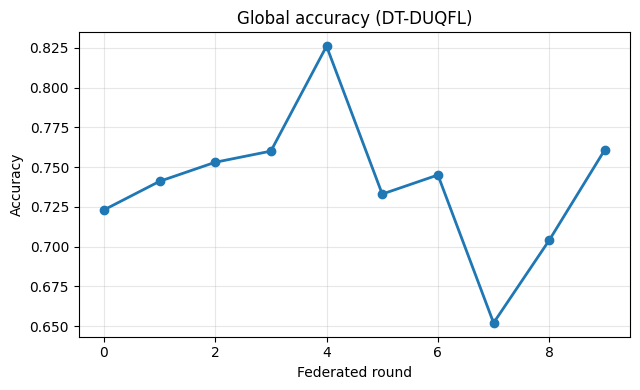

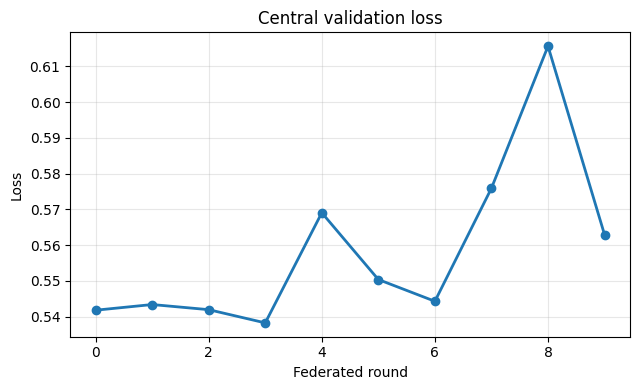

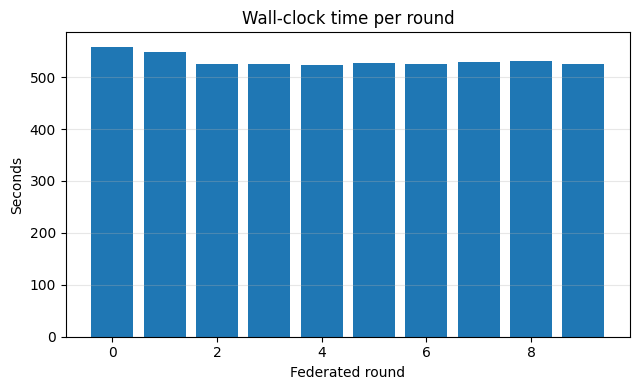

In [7]:
from training.loop import run_federated_training
from configs.base_config import use_teleportation as CFG_TEL, noise_preset, shots_used,aggregation
from training.metrics import metrics_init, metrics_log_round, metrics_finalize, compute_auc,metrics_summarize
from viz.plots import plot_accuracy_curve, plot_val_loss, plot_time_per_round, plot_fidelity_vs_delta_acc, plot_beta_hist, plot_client_fairness_last_round
# Initialize metrics store once
metrics_store = metrics_init(
    log_path=os.path.join(drive_root, "teleport_metrics_Perturb_shrink.csv")
)

#new
from ml import optimizers as mlopt
from configs.base_config import drive_root
import os

mlopt.meta_trace_enable(
    path=os.path.join(drive_root, "meta_trace.csv"),  # or None to skip CSV
    every=5                                           # print every 5 callbacks
)

###########
global_acc, clients_train, clients_test, round_times, val_losses, info_last = run_federated_training(
    clients=clients,
    num_federated_layers=num_federated_layers,
    num_deep_unfolding_iterations=num_deep_unfolding_iterations,
    initial_learning_rate=initial_learning_rate,
    initial_perturbation=initial_perturbation,
    num_features=num_features,
    best_client_csv_file=best_client_csv_file,
    global_csv_file=global_csv_file,
    local_csv_file=local_csv_file,
    validation_csv_file=validation_csv_file,
    test_sequences=test_sequences,
    test_labels=test_labels,
    X_val=X_val,
    y_val=y_val,
    use_teleportation=CFG_TEL,          # ← important
    noise_preset=noise_preset,
    shots_used=shots_used,
    metrics=metrics_store,   # <-- pass it in
    aggregation=aggregation           # <--- switch here
)

rows_np = metrics_finalize(metrics_store)   # if you need the in-memory array
#summary = metrics_summarize(metrics_store)  # prints a concise summary, returns a dict

# quick visuals
rounds = list(range(len(global_acc)))
plot_accuracy_curve(rounds, global_acc, label="Global accuracy (DT-DUQFL)")
plot_val_loss(rounds, val_losses, label="Central validation loss")
plot_time_per_round(rounds, round_times)

if info_last is not None:
    # this uses "last" round's info; in your logger you kept per-round arrays; adapt if needed
    pass
